[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLE.ipynb)

# Maximum Likelihood

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# Set random seed for reproducibility
# This ensures everyone gets the same random samples when running the notebook
np.random.seed(1234)

Lets assume that a thumbtack has a probability $0 < \theta^* < 1$ of _heads_ .
We use a **Bernoulli** distribution [$\mathrm{Bernoulli}(x | \theta) = \theta^{x} (1-\theta)^{1-x}$] to model this

In [2]:
# Define the Bernoulli probability mass function (PMF)
# Bernoulli(theta, x) = theta^x * (1-theta)^(1-x)
# For x=1 (heads): returns theta
# For x=0 (tails): returns (1-theta)
# 
# This function supports broadcasting:
# - If theta is scalar and x is array, computes PMF for each x value
# - If both are arrays of compatible shapes, computes element-wise PMF
Bernoulli = lambda theta, x: theta**x * (1-theta)**(1-x)

# True probability of heads for our thumbtack
theta_star = .4

# Example: probability of tails (x=0) when theta=0.4
# Should return 0.6 = (1-0.4)
Bernoulli(theta_star, 0)

0.6

The **likelihood** function for this dataset is
$$L(\theta) = \prod_{n=1}^{10} \mathrm{Bernoulli}(\theta, x^{(n)})$$
Note that this is a function of $\theta$, it is not a probability distribution, so it doesn't sum to 1.
Next we plot this function for $n$ randomly generated samples using $\theta^*$.

observation [1 0 0 0 0 1 1 0 0 0]


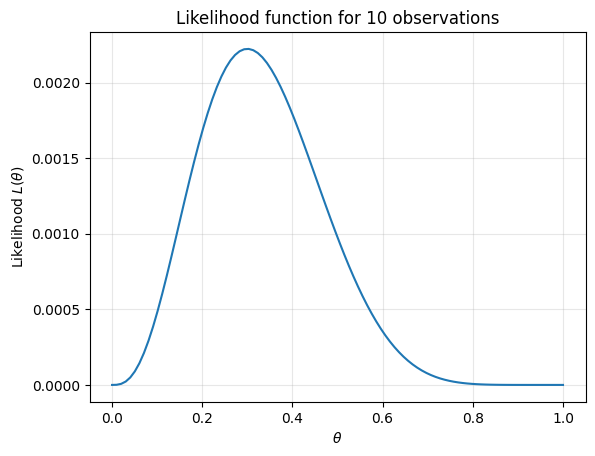

In [3]:
# Number of random coin flips to observe
n = 10

# Generate n random coin flips from the true distribution
# np.random.rand(n) generates n uniform random numbers in [0, 1)
# Comparing with theta_star gives boolean array: True with probability theta_star
# This simulates n independent Bernoulli trials
xn = np.random.rand(n) < theta_star

# Convert boolean array to integers for mathematical operations
# True -> 1 (heads), False -> 0 (tails)
xn = xn.astype(int)

print("observation {}".format(xn))

# Define the likelihood function L(theta)
# Likelihood = product of P(x_i | theta) for all observations
# L(theta) = ∏ Bernoulli(theta, x_i)
#
# Advanced indexing explanation:
# - theta: can be shape (K,) for K different theta values to evaluate
# - xn[None, :]: adds a dimension, transforming (n,) -> (1, n)
#   This is the same as xn[np.newaxis, :] or xn.reshape(1, -1)
# - Broadcasting: (K,) theta with (1, n) xn -> (K, n) result
# - axis=-1: product over last axis (the n observations)
# - Final output shape: (K,) - one likelihood value per theta
L = lambda theta: np.prod(Bernoulli(theta, xn[None, :]), axis=-1)

# Generate 100 evenly spaced theta values from 0 to 1 for visualization
# [:, None] adds a dimension: (100,) -> (100, 1)
# This makes theta_vals broadcastable with xn[None, :] which is (1, n)
# Broadcasting pattern: (100, 1) with (1, n) -> (100, n)
theta_vals = np.linspace(0, 1, 100)[:, None]

# Plot the likelihood function
plt.plot(theta_vals, L(theta_vals), '-')
plt.xlabel(r"$\theta$")
plt.ylabel(r"Likelihood $L(\theta)$")
plt.title("Likelihood function for {} observations".format(n))
plt.grid(True, alpha=0.3)
plt.show()

**maximum likelihood** method for learning a probabilistic model picks $\theta$ that maximizes $L(\theta)$ for a given set of observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$. 
For _Bernoulli_ dist. max. likelihood estimate is the $\widehat{\theta} = \frac{1}{N} \sum_n x^{(n)}$, corresponding to the peak of the likelihood plot. The value of the likelihood shrinks exponentially as we increase the number of observations $N$ -- try `N=100`. 
A more numerically stable value with the same _maximum_ is the **log-likelihood** $\ell(\theta) = \log(L(\theta))$. It is also customary to minimize the _negative log-likelihood_ (NLL).
Let's plot NLL for different $N$ -- as we increase our data-points the ML estimate often gets better.

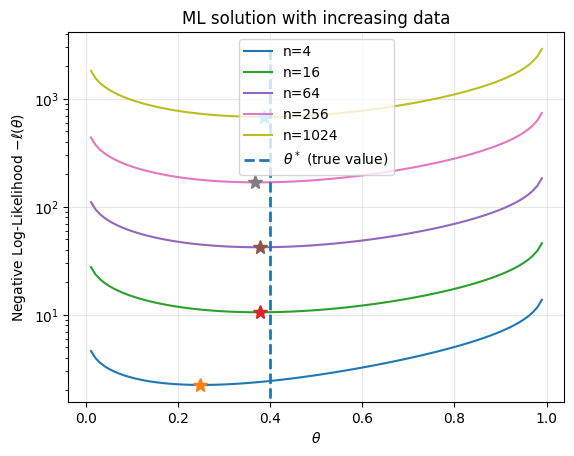

In [4]:
# Generate a large dataset of 2^12 = 4096 samples to use for different experiments
# We'll take subsets of this data to show how ML estimate improves with more data
xn_max = np.random.rand(2**12) < theta_star

# Iterate over different dataset sizes: 4, 16, 64, 256, 1024
for r in range(1, 6):
    # Number of samples for this iteration: 4^1, 4^2, 4^3, 4^4, 4^5
    n = 4**r
    
    # Slice the first n samples from our large dataset
    # This is array slicing: xn_max[:n] means "elements from index 0 to n-1"
    # Result shape: (n,)
    xn = xn_max[:n]
    
    # Define the log-likelihood function ℓ(theta)
    # Log-likelihood = sum of log(P(x_i | theta)) for all observations
    # ℓ(theta) = Σ log(Bernoulli(theta, x_i))
    #
    # Why log-likelihood instead of likelihood?
    # 1. Numerically stable: products of small probabilities underflow
    # 2. Easier to optimize: sum is easier than product
    # 3. Same maximizer: log is monotonic, so argmax doesn't change
    #
    # Advanced indexing (same pattern as likelihood function):
    # - theta: shape (K,) for K different theta values
    # - xn[None, :]: shape (1, n) - adds dimension for broadcasting
    # - Bernoulli(theta, xn[None, :]): shape (K, n) via broadcasting
    # - np.log: element-wise logarithm, still (K, n)
    # - axis=-1: sum over last axis (the n observations)
    # - Final output shape: (K,) - one log-likelihood value per theta
    ll = lambda theta: np.sum(np.log(Bernoulli(theta, xn[None, :])), axis=-1)
    
    # Create theta values to evaluate (avoid 0 and 1 to prevent log(0))
    # Shape: (100, 1) for broadcasting
    theta_vals = np.linspace(.01, .99, 100)[:, None]
    
    # Compute negative log-likelihood (NLL)
    # We plot NLL because it's standard to minimize (not maximize)
    # Minimizing NLL ≡ Maximizing log-likelihood ≡ Maximizing likelihood
    ll_vals = -ll(theta_vals)
    
    # Plot NLL curve for this dataset size
    plt.plot(theta_vals, ll_vals, label="n="+str(n))
    
    # Find the theta that minimizes NLL (Maximum Likelihood Estimate)
    # np.argmin returns the index of the minimum value
    max_ind = np.argmin(ll_vals)
    
    # Mark the MLE with a star
    plt.plot(theta_vals[max_ind], ll_vals[max_ind], '*', markersize=10)

# Draw a vertical dashed line at the true theta value
# This helps visualize how close our estimates are to the truth
# [0, ll_vals.max()] defines the y-coordinates for the line endpoints
plt.plot([theta_star, theta_star], [0, ll_vals.max()], '--', 
         label=r"$\theta^*$ (true value)", linewidth=2)

# Labels and formatting
plt.xlabel(r"$\theta$")
plt.ylabel(r"Negative Log-Likelihood $-\ell(\theta)$")

# Use log scale for y-axis to better visualize the curves
# NLL grows roughly linearly with n, so log scale helps compare different n
plt.yscale("log")

plt.title("ML solution with increasing data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Key observations:
# 1. As n increases, the minimum (marked with *) moves closer to theta_star
# 2. The curves become sharper (more confident) with more data
# 3. All curves have their minimum near theta_star (the true parameter)